---

# **PROJETO** | Análise Exploratória de Dados em Python: Entregas da Loggi no DF

[João Paulo Chiavegatto]()

---

# Tópicos

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>





# ANÁLISE EXPLORATÓRIA DE DADOS DE LOGÍSTICA

## 1\. Contexto


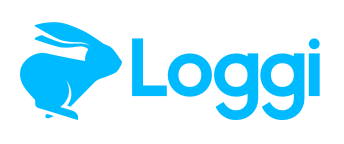

### 1.1 Problema de negócio

A [Loggi](https://www.loggi.com/) é uma startup brasileira de tecnologia focada em **logística**, que nasceu em 2013 operando exclusivamente na entrega de documentos. Dois anos depois, entrou no segmento de e-commerce e, desde 2017, também atua nas entregas de alimentos.

Nesta análise, como exercício para o módulo 16 do **curso** ***Analista de Dados*** **da EBAC**  vamos explorar dados retirados do [Loggi BUD](https://github.com/loggi/loggibud) (*Benchmark for Urban Deliveries*) - um repositório do GitHub com dados (sintetizados de fontes públicas como o IPEA e o IBGE) e códigos para problemas típicos enfrentados por empresas de logística - buscando retirar insights que possam ser utilizados para otimizar a operação da Loggi em no Distrito Federal.

###1.2 Dados

Vamos trabalhar com um sub conjunto dos dados originais presentes neste [link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). Para esse exercício, o professor André Perez consolidou em um único arquivo `JSON` as instâncias de treino de `cvrp` da cidade de Brasília.

## 2\. Pacotes e Bibliotecas

In [ ]:
#Importa a biblioteca nativa 'json', para manipulação de dados no formato JSON.
import json

#Importa a biblioteca 'pandas' para manipulação e análise de dados.
import pandas as pd
#Importa a biblioteca 'geopy' para geocodificação e cálculos de distância geográfica.
import geopy
#Importa a classe 'Nominatim' da biblioteca 'geopy.geocoders' para geocodificação.
from geopy.geocoders import Nominatim
#Importa a classe RateLimiter da biblioteca geopy.extra.rate_limiter para limitar a taxa de solicitações a um serviço.
from geopy.extra.rate_limiter import RateLimiter
#Importa a função 'great_circle' da biblioteca 'geopy.distance' para calcular distâncias entre coordenadas geográficas.
from geopy.distance import great_circle
#Importa a biblioteca 'numpy' para computação numérica.
import numpy as np
#Instalando e importando para o projeto a biblioteca `geopandas` para manipulação de dados geoespaciais
!pip3 install geopandas;
import geopandas
#Importando a biblioteca `matplotlib` para visualização de dados e geração de gráficos
import matplotlib.pyplot as plt
#Importante a biblioteca `seaborn` para visualização de dados e geração de gráficos
import seaborn as sns

##3\. Exploração de Dados

###3.1 Coleta

O dado bruto é um arquivo do tipo JSON com uma lista de instâncias de entregas. Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do hub (centro de distribuição) regional. O dado bruto está disponível para download neste [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Vamos realizar o seu download num arquivo `JSON` com o nome `deliveries.json` e carregar seus dados em um dicionário Python chamado `data`:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

  if data is not None:
    print(f'Foram carregados com sucesso **{len(data)}** dados do arquivo JSON.')
  else:
    print('Falha ao carregar dados do arquivo JSON')

Foram carregados com sucesso **199** dados do arquivo JSON.


Vamos explorar um exemplo no dicionário `data`:



In [ ]:
example = data[0]

In [ ]:
print(example.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [ ]:
example['name']

'cvrp-2-df-33'

In [ ]:
example['region']

'df-2'

In [ ]:
example['origin']

{'lng': -48.05498915846707, 'lat': -15.83814451122274}

In [ ]:
example['origin']['lat']

-15.83814451122274

In [ ]:
example['origin']['lng']

-48.05498915846707

In [ ]:
example['vehicle_capacity']

180

In [ ]:
example['deliveries'][0]['point']['lat']

-15.848929154862294

In [ ]:
example['deliveries'][0]['point']['lng']

-48.11618888384239

###3.2 Wrangling

In [ ]:
deliveries_df = pd.DataFrame(data)

print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 199 linhas e 5 séries.


In [ ]:
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


- **Normalizando** a coluna `origin`



Identificamos que a coluna `origin` apresenta dados aninhados (*nested*) na estrutura JSON - longitude (`lng`) e latitude (`lat`). Vamos `normalizar` a coluna com uma operação de achatamento (`flatten`), transformando cada chave JSON em uma nova coluna:

In [ ]:
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
print(f'Dataframe criado com sucesso, contendo {hub_origin_df.shape[0]} linhas e {hub_origin_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 199 linhas e 2 séries.


In [ ]:
hub_origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Após o achatamento dos dados, vamos juntá-los ao dataframe principal:

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 199 linhas e 7 séries.


Com isso, a coluna `origin` se torna redundante e pode ser excluida do dataframe principal. Vamos também reorganizar a posição das colunas para agrupar à esquerda as informações referentes aos hubs e à direita as informações referentes aos deliveries:

In [ ]:
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 199 linhas e 6 séries.


Vamos renomear as novas colunas para diferenciar as informações geográficas referentes ao hub daqueles referentes aos deliveries:


In [ ]:
deliveries_df.rename(columns={'lng':'hub_lng', 'lat':'hub_lat'}, inplace=True)

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


- **Normalizando** a coluna `deliveries`

Constata-se que a coluna `deliveries` também tem dados aninhados. Porém, ao contrário da coluna `origin`, que continha o equivalente a um dicionário python com duas chaves, esta contém o equivalente a uma lista com diversos dicionários python. Portanto, vamos utilizar primeiramente o método de explosão (`explode`) para transformar cada item da lista em uma linha no dataframe **antes** de achatar a coluna:



In [ ]:
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')
print(f'Dataframe criado com sucesso, contendo {deliveries_exploded_df.shape[0]} linhas e {deliveries_exploded_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 1 séries.


In [ ]:
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


Para preservar o índice do dataframe principal, precisaremos de uma estrutura ligeiramente diferente daquela usada no primeiro processo de achatamento. Isso garantirá que cada linha da coluna `deliveries` que foi "explodida" - assim como das novas colunas que surgirão do achatamento - permaneça lastreada seu hub de origem correspondente.

In [ ]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
print(f'Dataframe criado com sucesso, contendo {deliveries_normalized_df.shape[0]} linhas e {deliveries_normalized_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 3 séries.


In [ ]:
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Após a explosão e achatamento dos dados, vamos juntá-los ao dataframe principal. Novamente, a coluna normalizada se torna redundante e pode ser excluída.

In [ ]:
len(deliveries_df)

199

In [ ]:
len(deliveries_exploded_df)

636149

In [ ]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 8 séries.


In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


###3.3 Estrutura

Agora, tendo em mão os principais dados, vamos explorar melhor a estrutura do dataframe.

In [ ]:
deliveries_df.shape

(636149, 8)

In [ ]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [ ]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


###3.4 Schema

In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [ ]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

- Atributos **categóricos**.

In [ ]:
deliveries_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


- Atributos **numéricos**.

In [ ]:
deliveries_df.drop(['name', 'region'], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [ ]:
deliveries_df.drop(['name', 'region'], axis=1).select_dtypes('float64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


###3.5 Dados Faltantes

In [ ]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

##4\. Manipulação

###4.1 Enriquecimento

- Geocodificação reversa do hub

A `geocodificação` é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A `geocodificação reversa` faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

In [ ]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
print(f'Dataframe criado com sucesso, contendo {hub_df.shape[0]} linhas e {hub_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 3 linhas e 3 séries.


In [ ]:
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Neste processo, vamos utilizar o serviço [Nominatim](https://nominatim.org/) - disponibilizado gratuitamente pelo [OpenStreetMap](https://www.openstreetmap.org/) - através do pacote python `geopy` para enriquecer o dataframe principal.

In [ ]:
geolocator = Nominatim(user_agent='projeto_geocoder')

In [ ]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df['coordinates'] = hub_df['hub_lat'].astype(str) + ', ' + hub_df['hub_lng'].astype(str)
hub_df['geodata'] = hub_df['coordinates'].apply(geocoder)
print(f'Dataframe criado com sucesso, contendo {hub_df.shape[0]} linhas e {hub_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 3 linhas e 5 séries.


In [ ]:
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Feita a geocodificação reversa dos hubs (`region`), vamos normalizar os dados da coluna `geodata` e extrair informações de `cidade` e `bairro`.

In [ ]:
hub_geodata_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
print(f'Dataframe criado com sucesso, contendo {hub_geodata_df.shape[0]} linhas e {hub_geodata_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 3 linhas e 31 séries.


In [ ]:
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [ ]:
hub_geodata_df = hub_geodata_df[['address.town', 'address.suburb', 'address.city']]
hub_geodata_df.rename(columns={'address.town':'hub_town', 'address.suburb':'hub_suburb', 'address.city':'hub_city'}, inplace=True)
#Onde hub_geodata_df['hub_city'] não for NaN, manter 'hub_city'. Onde for NaN, 'hub_geodata_df['hub_town']
hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
#Onde hub_geodata_df['hub_suburb'] não for NaN, manter 'hub_suburb'. Onde for NaN, 'hub_geodata_df['hub_city']
hub_geodata_df['hub_suburb'] = np.where(hub_geodata_df['hub_suburb'].notna(), hub_geodata_df['hub_suburb'], hub_geodata_df['hub_city'])
#hub_geodata_df['hub_town'] se torna redundante e pode ser excluída.
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-48-1b89372760ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={'address.town':'hub_town', 'address.suburb':'hub_suburb', 'address.city':'hub_city'}, inplace=True)
<ipython-input-48-1b89372760ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df['hub_city'] = np.where(hub_geodata_df['hub_city'].notna(), hub_geodata_df['hub_city'], hub_geodata_df['hub_town'])
<ipython-input-48-1b89372760ec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Feita a normalização dos dados, vamos adicionar as informações das novas colunas `hub_city` e `hub_suburb` ao dataframe principal:

In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'hub_suburb', 'hub_city']]
print(f'Dataframe criado com sucesso, contendo {hub_df.shape[0]} linhas e {hub_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 3 linhas e 3 séries.


In [ ]:
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 10 séries.


In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


- Geocodificação reversa dos deliveries

O serviço gratuito de consulta ao servidor do Nominatim comporta apenas 1 consulta por segundo e demoraria em torno de 7 dias para serem realizadas nas 636.149 coordenadas referentes aos deliveries. Portanto, o professor André Perez realizou esse processo em sua máquina local e consolidou os dados (já normalizados) no arquivo `deliveries-geodata.csv`, que pode ser acessado no link abaixo:

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
print(f'Dataframe criado com sucesso, contendo {deliveries_geodata_df.shape[0]} linhas e {deliveries_geodata_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 4 séries.


In [ ]:
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[['delivery_city', 'delivery_suburb']], how='inner', left_index=True, right_index=True)
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 12 séries.


In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


- Medindo a distância entre hub e ponto de entrega (delivery)

In [ ]:
deliveries_df['distance'] = deliveries_df.apply(lambda row: great_circle((row['hub_lat'], row['hub_lng']), (row['delivery_lat'], row['delivery_lng'])).kilometers, axis=1)
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 13 séries.


In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905411
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244589
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018


- Acrescentando o censo populacional dos bairros do DF em `delivery_city_pop`

Para esses dados, recorremos ao repositório de dados SISDIA, que agrupou no arquivo `Censo_Populacional_2010.csv` as informações da SEDU-DF (*Secretaria de Estado de Desenvolvimento Urbano e Habitação do Distrito Federal*).

In [ ]:
!wget -q "https://raw.githubusercontent.com/jpchiavegatto/ebac-analise-exploratoria-logistica/main/Censo_Populacional_2010.csv" -O Censo_Populacional_2010.csv

In [ ]:
delivery_city_pop_df = pd.read_csv('Censo_Populacional_2010.csv')
delivery_city_pop_df = delivery_city_pop_df[['ra', 'pop_total']]
delivery_city_pop_df['ra'] = delivery_city_pop_df['ra'].str.title()
delivery_city_pop_df.rename(columns={'ra':'delivery_city', 'pop_total':'delivery_city_pop'}, inplace=True)
delivery_city_pop_df = delivery_city_pop_df.drop_duplicates(subset='delivery_city')

print(f'Dataframe criado com sucesso, contendo {delivery_city_pop_df.shape[0]} linhas e {delivery_city_pop_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 31 linhas e 2 séries.


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=delivery_city_pop_df, on='delivery_city', how='left')
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 14 séries.


- Acrescentando dados sobre o poder aquisitivo das regiões do DF em `delivery_city_income`. Para esses dados, recorremos ao repositório de dados SISDIA, que agrupou no arquivo `Poder_Aquisitivo.csv` as informações do IBGE/CODEPLAN.

In [ ]:
!wget -q "https://raw.githubusercontent.com/jpchiavegatto/ebac-analise-exploratoria-logistica/main/Poder_Aquisitivo.csv" -O Poder_Aquisitivo.csv

In [ ]:
delivery_city_income_df = pd.read_csv('Poder_Aquisitivo.csv')
delivery_city_income_df = delivery_city_income_df[['ra_nome', 'renda_media_mensal']]
delivery_city_income_df['ra_nome'] = delivery_city_income_df['ra_nome'].str.title()
delivery_city_income_df.rename(columns={'ra_nome':'delivery_city', 'renda_media_mensal':'delivery_city_income'}, inplace=True)
delivery_city_income_df = delivery_city_income_df.drop_duplicates(subset='delivery_city')
print(f'Dataframe criado com sucesso, contendo {delivery_city_pop_df.shape[0]} linhas e {delivery_city_pop_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 31 linhas e 2 séries.


In [ ]:
delivery_city_income_df.head()

,delivery_city,delivery_city_income
0,Lago Sul,18950.96
1,Lago Norte,14084.57
2,Brasília,10484.55
3,Guará,6016.32
4,Taguatinga,4427.16


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=delivery_city_income_df, on='delivery_city', how='left')
print(f'Dataframe criado com sucesso, contendo {deliveries_df.shape[0]} linhas e {deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 15 séries.


In [ ]:
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance,delivery_city_pop,delivery_city_income
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,405932.0,2351.83
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905411,405932.0,2351.83
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244589,405932.0,2351.83
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,405932.0,2351.83
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,NaN,NaN


###4.2 Qualidade

Vamos verificar a consistência do `schema` e a ocorrência de dados faltantes ou nulos.

In [ ]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   name                  636149 non-null  object 
 1   region                636149 non-null  object 
 2   hub_lng               636149 non-null  float64
 3   hub_lat               636149 non-null  float64
 4   hub_city              636149 non-null  object 
 5   hub_suburb            636149 non-null  object 
 6   vehicle_capacity      636149 non-null  int64  
 7   delivery_size         636149 non-null  int64  
 8   delivery_lng          636149 non-null  float64
 9   delivery_lat          636149 non-null  float64
 10  delivery_city         634447 non-null  object 
 11  delivery_suburb       476264 non-null  object 
 12  distance              636149 non-null  float64
 13  delivery_city_pop     377360 non-null  float64
 14  delivery_city_income  515804 non-null  float64
dtype

In [ ]:
deliveries_df.isna().any()

name                    False
region                  False
hub_lng                 False
hub_lat                 False
hub_city                False
hub_suburb              False
vehicle_capacity        False
delivery_size           False
delivery_lng            False
delivery_lat            False
delivery_city            True
delivery_suburb          True
distance                False
delivery_city_pop        True
delivery_city_income     True
dtype: bool

Constatamos a presença de dados faltantes nas colunas `delivery_city`, `delivery_city_income` e, mais expressivamente, `delivery_suburb` e `delivery_city_pop`. Vamos verificar sua prevalência no conjunto de dados.

In [ ]:
100 * (deliveries_df['delivery_city'].isna().sum() / len(deliveries_df))

0.26754738276724477

In [ ]:
100 * (deliveries_df['delivery_suburb'].isna().sum() / len(deliveries_df))

25.133262804783158

In [ ]:
100 * (deliveries_df['delivery_city_pop'].isna().sum() / len(deliveries_df))

40.68056383017186

In [ ]:
100 * (deliveries_df['delivery_city_income'].isna().sum() / len(deliveries_df))

18.91773782557231

`delivery_city` contém **0.26%** de dados faltantes,

`delivery_suburb` **25.13%** de dados faltantes,

`delivery_city_pop` **40.68%** de dados faltantes,

`delivery_city_income` **18.91%** de dados faltantes.

In [ ]:
prop_df = deliveries_df[['delivery_city']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(n=10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

**23%** dos dados de `delivery_city` correspondem a `"Brasília"`, uma informação tecnicamente inválida - posto que para os efeitos dessa análise Brasília não é considerada uma cidade.

In [ ]:
prop_df = deliveries_df[['delivery_suburb']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(n=10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

**8%** dos dados de `delivery_suburb` correspondem a `"Brasília"`, uma informação tecnicamente inválida - posto que para os efeitos dessa análise Brasília não é considerada um bairro.

##5\. Visualização

###5.1 Mapa de Entregas Por Região

Vamos utilizar o pacote Python GeopPandas para visualizar as coordenadas dos hubs e das entregas no mapa do DF, segmentados pela região dos hubs. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

- Mapa do DF

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`.

In [ ]:
!wget 'https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip' -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

--2023-10-26 23:47:15--  https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122654303 (117M) [application/zip]
Saving to: ‘distrito-federal.zip’

distrito-federal.zi 100%[===================>] 116.97M  22.8MB/s    in 6.0s    

2023-10-26 23:47:21 (19.4 MB/s) - ‘distrito-federal.zip’ saved [122654303/122654303]



In [ ]:
mapa = geopandas.read_file('distrito-federal.shp')
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


- Mapa dos hubs

Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
hub_df = deliveries_df[['region', 'hub_lng', 'hub_lat']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df['hub_lng'], hub_df['hub_lat']))
print(f'Dataframe criado com sucesso, contendo {geo_hub_df.shape[0]} linhas e {geo_hub_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 3 linhas e 4 séries.


In [ ]:
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


- Mapa dos deliveries

Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
print(f'Dataframe criado com sucesso, contendo {geo_deliveries_df.shape[0]} linhas e {geo_deliveries_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 16 séries.


In [ ]:
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,distance,delivery_city_pop,delivery_city_income,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,6.655516,405932.0,2351.83,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,6.905411,405932.0,2351.83,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,6.244589,405932.0,2351.83,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,6.806062,405932.0,2351.83,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,6.780018,NaN,NaN,POINT (-48.11490 -15.85805)


<ipython-input-82-cb51e7170d5c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


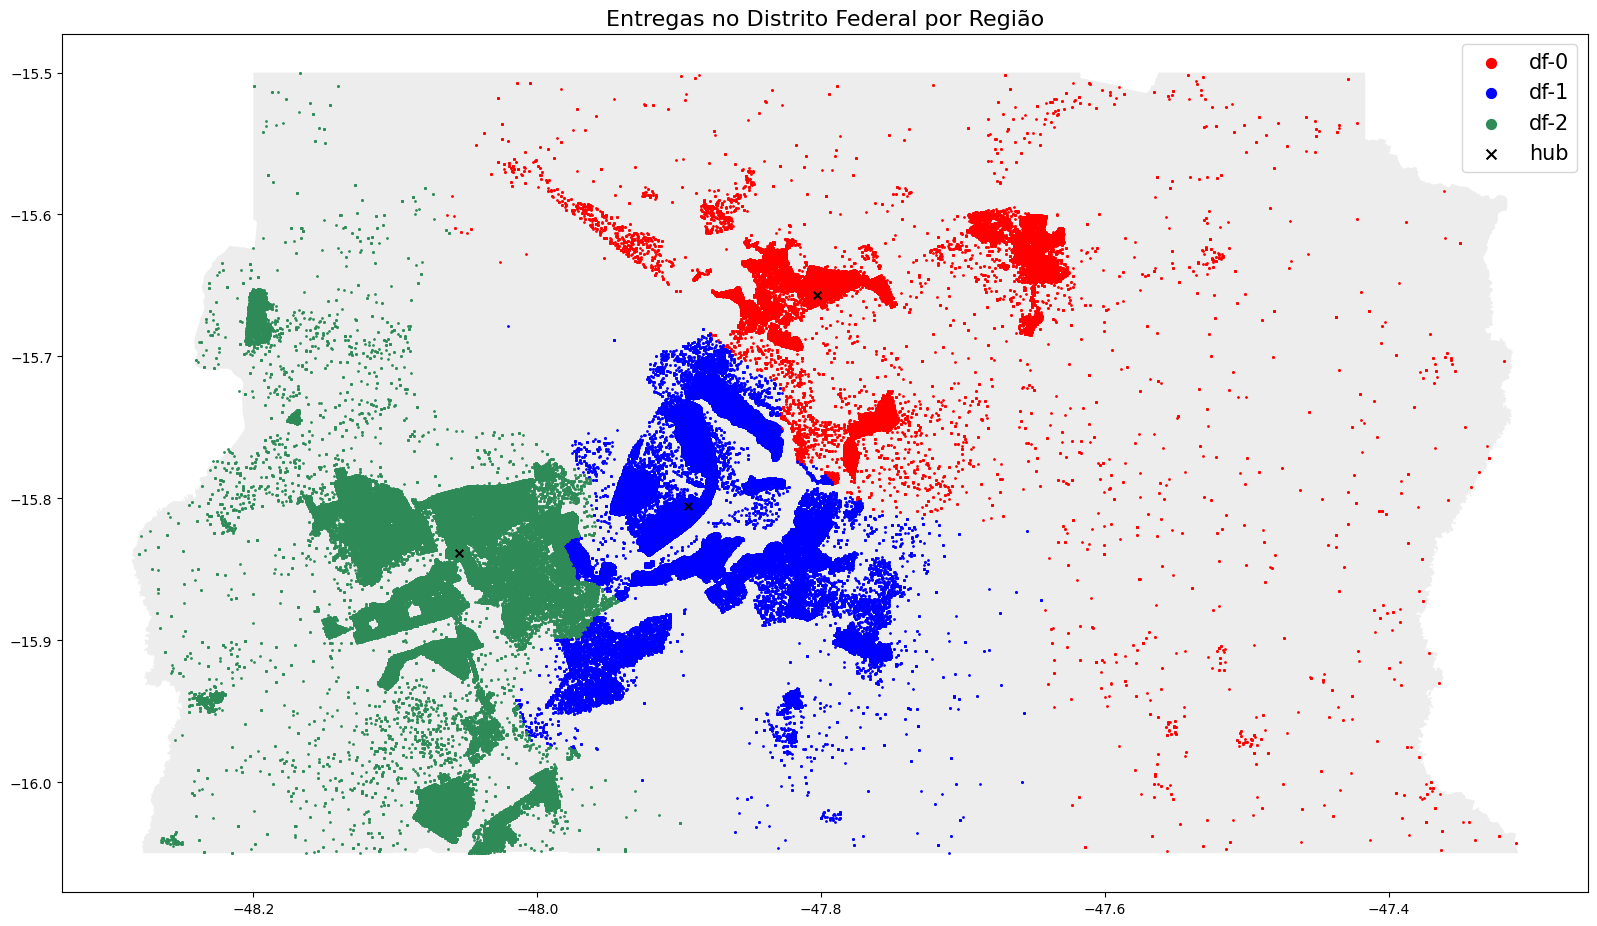

In [ ]:
#cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

#plot do mapa do DF
mapa.plot(ax=ax, alpha=0.4, color='lightgrey')

#plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

#plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

- **Insights**

1. As **entregas** estão corretamente alocadas aos seus respectivos **hubs**;
1. Os **hubs** das regiões 0 e 2 fazem **entregas** em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

###5.2 Entregas por Região

- Agregação

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: 'region_percent'}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


- Visualização

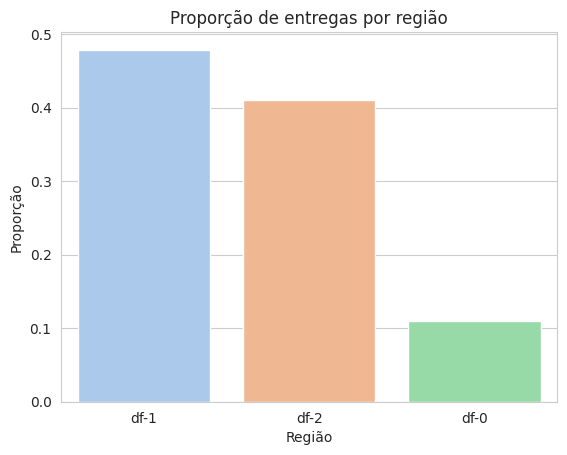

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x='region', y='region_percent', errorbar=None, palette='pastel')
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção')

- **Insights**

1. A distribuição das **entregas** está muito concentrada nos **hubs** das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.

###5.3 Distância das Entregas Por Região

In [ ]:
data_distance = pd.DataFrame(deliveries_df[['region', 'distance']])
data_distance_0 = data_distance.query("region == 'df-0'")
data_distance_1 = data_distance.query("region == 'df-1'")
data_distance_2 = data_distance.query("region == 'df-2'")

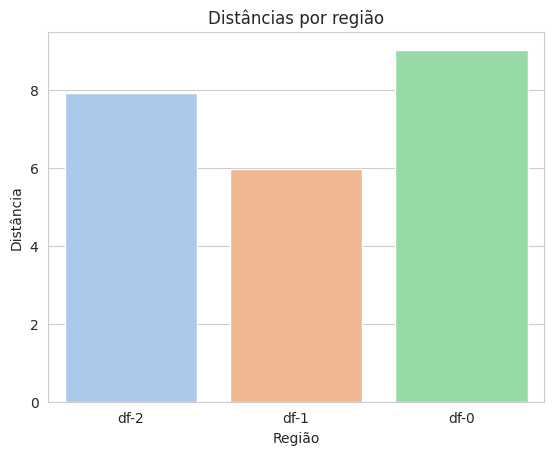

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_distance, x='region', y='distance', errorbar=None, palette='pastel')
  grafico.set(title='Distâncias por região', xlabel='Região', ylabel='Distância')

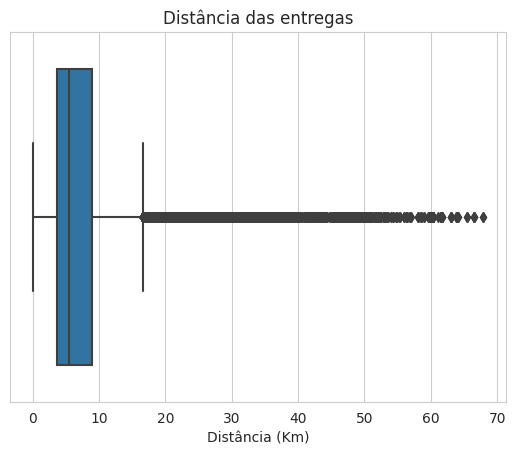

In [ ]:
with sns.axes_style('whitegrid'):

  distance = sns.boxplot(x=data_distance['distance'])
  distance.set(title='Distância das entregas', xlabel='Distância (Km)')

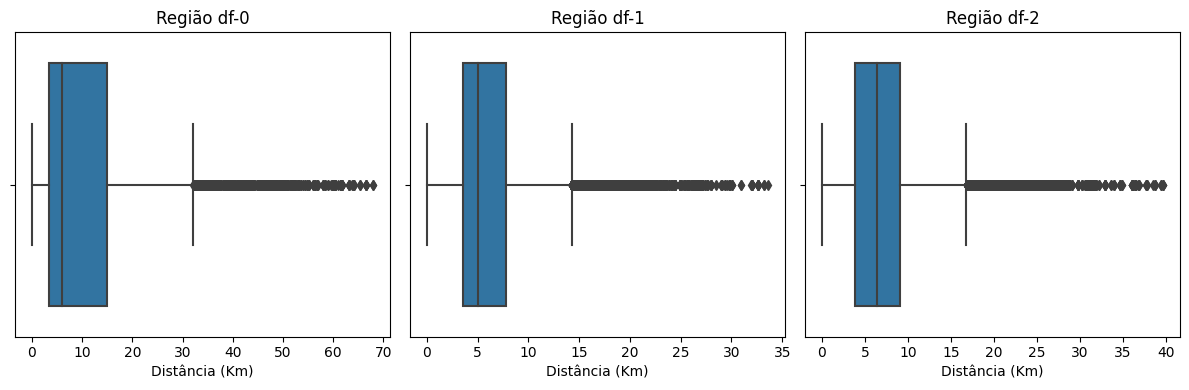

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.boxplot(x=data_distance_1['distance'], ax=axes[1])
axes[1].set_title('Região df-1')
axes[1].set_xlabel('Distância (Km)')

sns.boxplot(x=data_distance_2['distance'], ax=axes[2])
axes[2].set_title('Região df-2')
axes[2].set_xlabel('Distância (Km)')

sns.boxplot(x=data_distance_0['distance'], ax=axes[0])
axes[0].set_title('Região df-0')
axes[0].set_xlabel('Distância (Km)')

plt.tight_layout()

plt.show()

In [ ]:
data_distancias_outliers = data_distance.query("distance > 20")
data_distancias_outliers.head()

,region,distance
65,df-2,20.126776
99,df-2,20.119729
292,df-2,24.921136
293,df-2,25.291899
294,df-2,23.580439


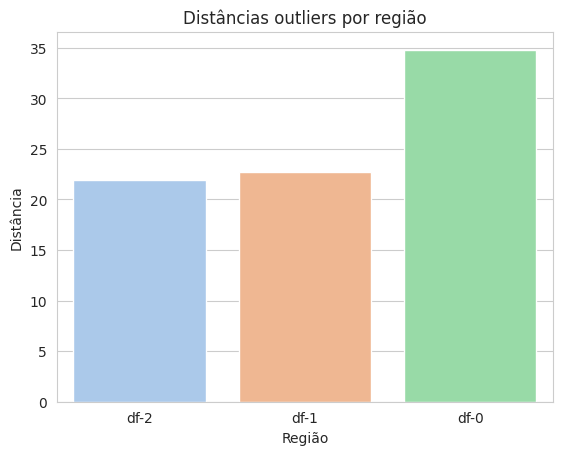

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data_distancias_outliers, x='region', y='distance', errorbar=None, palette='pastel')
  grafico.set(title='Distâncias outliers por região', xlabel='Região', ylabel='Distância')

- **Insights**



1.   As entregas da Loggi no Distrito Federal exibem uma tendência consistente de estar situadas em uma faixa de distância que varia de **0Km** a **17Km** dos seus hubs de origem. A maioria dessas entregas concentra-se principalmente em uma faixa mais estreita, compreendida entre **3Km** e **9Km**, indicando uma distribuição mais comum nesse intervalo. No entanto, vale destacar que existem casos atípicos, representados por outliers que se estendem até quase **70Km** de distância do hub, demonstrando uma variação significativa em distâncias em situações excepcionais.



2. O df-0, conforme evidenciado pelo Mapa das Entregas Por Região, destaca-se por apresentar uma maior variabilidade na distância das entregas que realiza. Estas, variam significativamente, com registros que se estendem desde **1Km** até **32Km**, embora a concentração principal esteja na faixa de **3Km** a **15Km**. Além disso, notam-se casos atípicos, representados por outliers, que alcançam distâncias de quase **70Km**.


###5.4 Entregas por bairro

In [ ]:
city_delivery_counts_df = deliveries_df[['delivery_city']]
print(f'Dataframe criado com sucesso, contendo {city_delivery_counts_df.shape[0]} linhas e {city_delivery_counts_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 1 séries.


In [ ]:
city_delivery_counts_df['count'] = 1
print(f'Dataframe criado com sucesso, contendo {city_delivery_counts_df.shape[0]} linhas e {city_delivery_counts_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 2 séries.


<ipython-input-91-0b9e8eeb7457>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_delivery_counts_df['count'] = 1


In [ ]:
city_delivery_counts_sum_df = city_delivery_counts_df.groupby('delivery_city')['count'].sum().reset_index()
print(f'Dataframe criado com sucesso, contendo {city_delivery_counts_sum_df.shape[0]} linhas e {city_delivery_counts_sum_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 38 linhas e 2 séries.


In [ ]:
city_delivery_counts_sum_df.head()

,delivery_city,count
0,Agrovila Café Sem Troco,37
1,Arniqueiras,7823
2,Brasília,148983
3,Brazlândia,6043
4,Café sem Troco,12


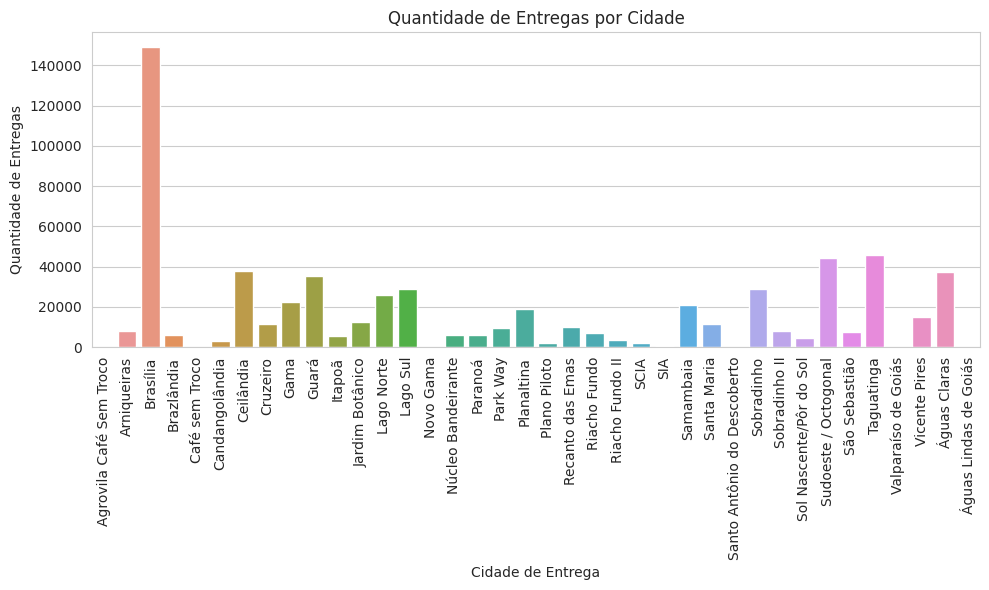

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(10, 6))
    grafico = sns.barplot(data=city_delivery_counts_sum_df, x="delivery_city", y="count")
    plt.xlabel('Cidade de Entrega')
    plt.ylabel('Quantidade de Entregas')
    plt.title('Quantidade de Entregas por Cidade')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

###5.5 Das regiões atendidas no DF

- Relação entregas por bairro vs nº de habitantes do bairro

In [ ]:
deliveries_city_pop_df = deliveries_df[['delivery_city', 'delivery_city_pop']]
print(f'Dataframe criado com sucesso, contendo {deliveries_city_pop_df.shape[0]} linhas e {deliveries_city_pop_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 636149 linhas e 2 séries.


In [ ]:
deliveries_city_pop_df.head()

,delivery_city,delivery_city_pop
0,Ceilândia,405932.0
1,Ceilândia,405932.0
2,Ceilândia,405932.0
3,Ceilândia,405932.0
4,Sol Nascente/Pôr do Sol,NaN


In [ ]:
city_count_pop_df = pd.merge(left=city_delivery_counts_sum_df, right=deliveries_city_pop_df, how='left', on='delivery_city')
city_count_pop_df = city_count_pop_df.drop_duplicates().sort_values(by='delivery_city').reset_index(drop=True)
print(f'Dataframe criado com sucesso, contendo {city_count_pop_df.shape[0]} linhas e {city_count_pop_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 38 linhas e 3 séries.


In [ ]:
city_count_pop_df.head()

,delivery_city,count,delivery_city_pop
0,Agrovila Café Sem Troco,37,NaN
1,Arniqueiras,7823,NaN
2,Brasília,148983,NaN
3,Brazlândia,6043,57974.0
4,Café sem Troco,12,NaN


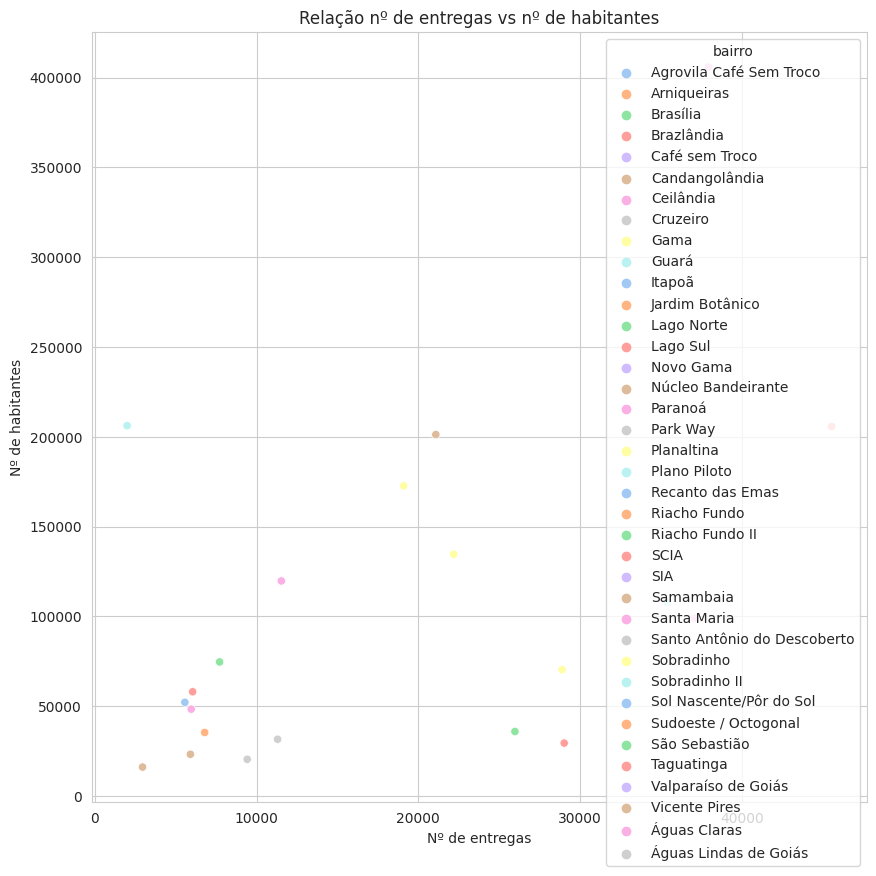

In [ ]:
with sns.axes_style('whitegrid'):

  plt.figure(figsize=(10, 10))

  grafico = sns.scatterplot(data=city_count_pop_df, x="count", y="delivery_city_pop", hue="delivery_city", palette="pastel")
  grafico.set(title='Relação nº de entregas vs nº de habitantes', xlabel='Nº de entregas', ylabel='Nº de habitantes');
  grafico.get_legend().set_title('bairro');

- **Insights**



1.   Como esperado, parece haver - em geral, mas não de forma absolutamente determinante - uma relação positiva entre o número de entregas realizadas em cada bairro e o tamanho da população do bairro.



- Relação entre entregas por bairro e renda média mensal

In [ ]:
city_income_df = deliveries_df[['delivery_city', 'delivery_city_income']]
city_income_df = city_income_df.drop_duplicates().sort_values(by='delivery_city').reset_index(drop=True)
print(f'Dataframe criado com sucesso, contendo {city_income_df.shape[0]} linhas e {city_income_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 39 linhas e 2 séries.


In [ ]:
city_income_df.head()

,delivery_city,delivery_city_income
0,Agrovila Café Sem Troco,NaN
1,Arniqueiras,NaN
2,Brasília,10484.55
3,Brazlândia,2443.12
4,Café sem Troco,NaN


In [ ]:
delivery_city_income_df = pd.merge(left=city_count_pop_df, right=city_income_df, how='left', on='delivery_city')
print(f'Dataframe criado com sucesso, contendo {delivery_city_income_df.shape[0]} linhas e {delivery_city_income_df.shape[1]} séries.')

Dataframe criado com sucesso, contendo 38 linhas e 4 séries.


In [ ]:
delivery_city_income_df.head()

,delivery_city,count,delivery_city_pop,delivery_city_income
0,Agrovila Café Sem Troco,37,NaN,NaN
1,Arniqueiras,7823,NaN,NaN
2,Brasília,148983,NaN,10484.55
3,Brazlândia,6043,57974.0,2443.12
4,Café sem Troco,12,NaN,NaN


In [ ]:
delivery_city_income_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   delivery_city         38 non-null     object 
 1   count                 38 non-null     int64  
 2   delivery_city_pop     21 non-null     float64
 3   delivery_city_income  21 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.5+ KB


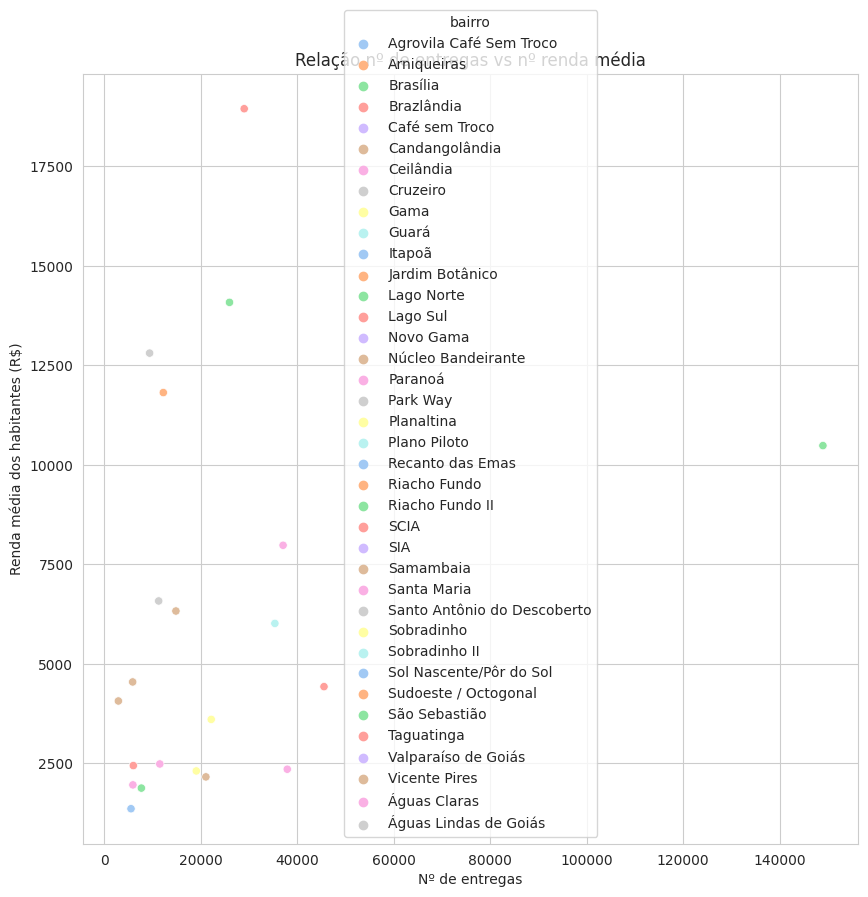

In [ ]:
with sns.axes_style('whitegrid'):

  plt.figure(figsize=(10, 10))

  grafico = sns.scatterplot(data=delivery_city_income_df, x="count", y="delivery_city_income", hue="delivery_city", palette="pastel")
  grafico.set(title='Relação nº de entregas vs nº renda média', xlabel='Nº de entregas', ylabel='Renda média dos habitantes (R$)');
  grafico.get_legend().set_title('bairro');

- **Insights**



2.   Assim como na relação de entregas por bairro vs nº de habitantes, a renda média dos bairros não parece impactar de forma determinante o nº de entregas realizadas.



###5.6 Do tamanho das entregas por **bairro**

In [ ]:
peso_delivery_df = deliveries_df[['delivery_city', 'delivery_size']]

In [ ]:
media_peso_delivery = peso_delivery_df.groupby('delivery_city')['delivery_size'].mean()
media_peso_delivery_df = pd.DataFrame(media_peso_delivery).reset_index()
media_peso_delivery_df = media_peso_delivery_df.drop_duplicates().reset_index(drop=True)

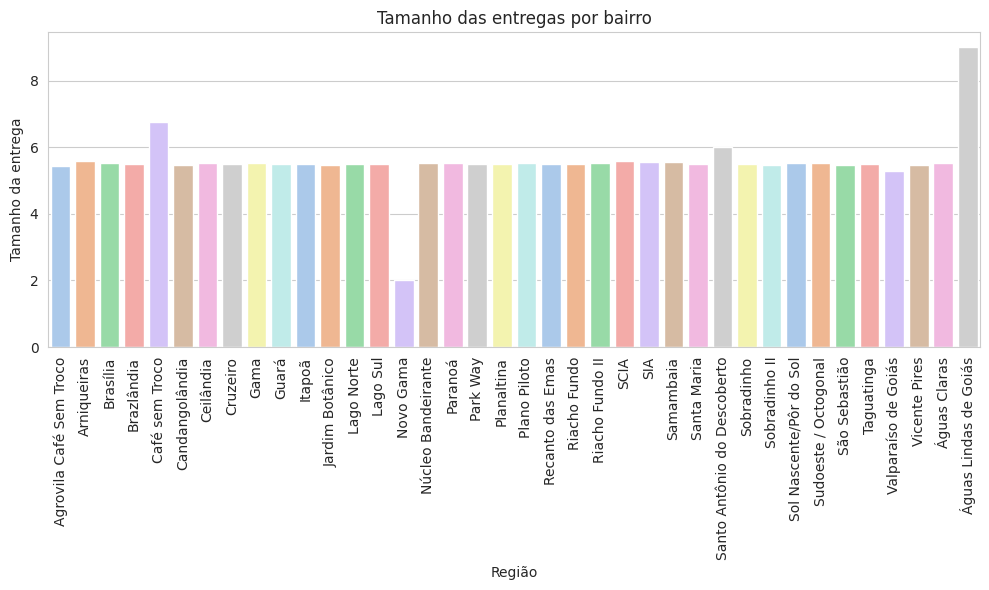

In [ ]:
with sns.axes_style('whitegrid'):
  plt.figure(figsize=(10, 6))
  grafico = sns.barplot(data=media_peso_delivery_df, x='delivery_city', y='delivery_size', errorbar=None, palette='pastel')
  grafico.set(title='Tamanho das entregas por bairro', xlabel='Região', ylabel='Tamanho da entrega')
  plt.xticks(rotation=90)

  plt.tight_layout()
  plt.show()

- **Insight**

1. A maioria dos bairros atendidos no DF tem, em média, entregas do tamanho 5, exceto pelos bairros ou distritos Café Sem Troco, Novo Gama e - mais expressivamente, Águas Lindas de Goiás.

###3.7 Da renda dos bairros atendidos

In [ ]:
income_df = deliveries_df[['region', 'delivery_city', 'delivery_city_income']]

In [ ]:
income_df.head()

,region,delivery_city,delivery_city_income
0,df-2,Ceilândia,2351.83
1,df-2,Ceilândia,2351.83
2,df-2,Ceilândia,2351.83
3,df-2,Ceilândia,2351.83
4,df-2,Sol Nascente/Pôr do Sol,NaN


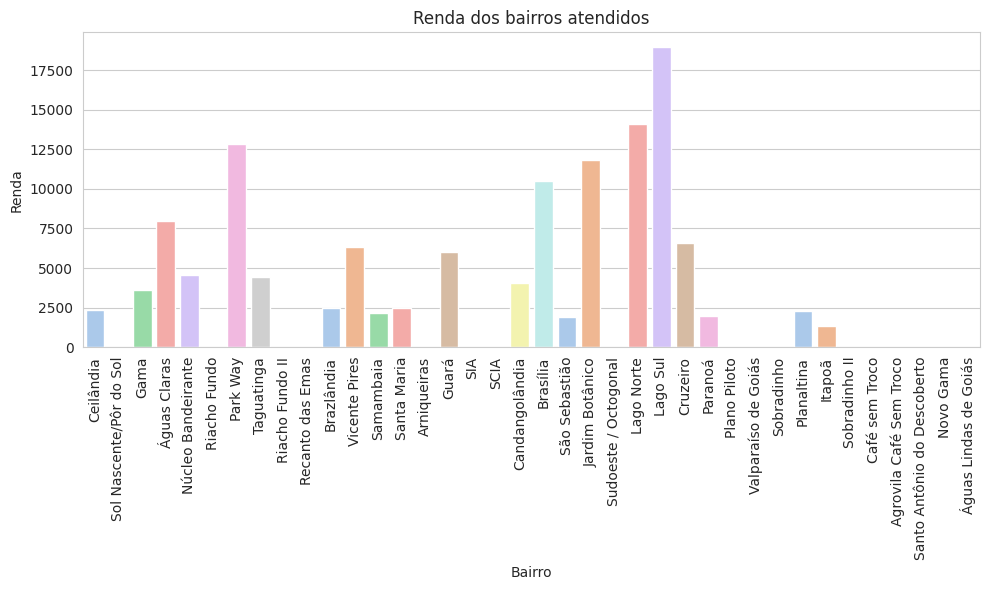

In [ ]:
with sns.axes_style('whitegrid'):
  plt.figure(figsize=(10, 6))
  grafico = sns.barplot(data=income_df, x='delivery_city', y='delivery_city_income', errorbar=None, palette='pastel')
  grafico.set(title='Renda dos bairros atendidos', xlabel='Bairro', ylabel='Renda')
  plt.xticks(rotation=90)

  plt.tight_layout()
  plt.show()

In [ ]:
renda_hub = income_df.groupby('region')['delivery_city_income'].mean()
media_renda_hub_df = pd.DataFrame(renda_hub).reset_index()

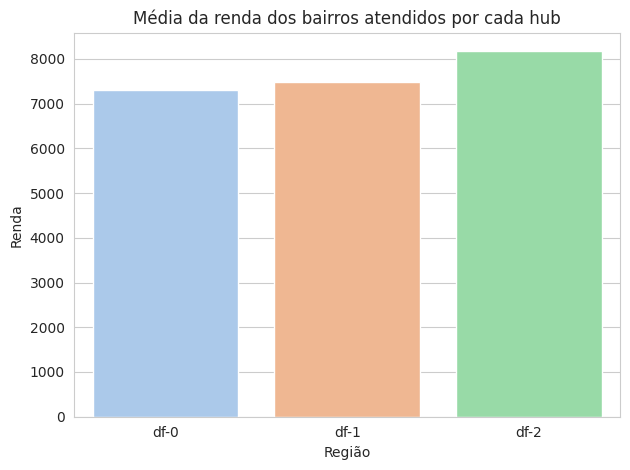

In [ ]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=media_renda_hub_df, x='region', y='delivery_city_income', errorbar=None, palette='pastel')
  grafico.set(title='Média da renda dos bairros atendidos por cada hub', xlabel='Região', ylabel='Renda')

  plt.tight_layout()
  plt.show()